# Project Setup

In [17]:
from __future__ import print_function
from __future__ import absolute_import

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display
import requests
from io import BytesIO
import tensorflow as tf

import tensorflow_hub as hub
tf.__version__

'2.11.0'

In [24]:
# UTILS
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        plt.imshow(image)
    if title:
        plt.title(title)

In [18]:
import sys
absolute_path_yamnet = '/home/claudio-unix/mae/ShapingMusic/yamnet_pkg'
sys.path.insert(1, absolute_path_yamnet)

In [19]:
# IMAGE_MODEL
image_model = tf.keras.applications.VGG19(
    include_top=True,
    weights='imagenet'
)

# AUDIO MODEL
from yamnet_pkg import inference
sound_model = inference.YamNet()

# TEXT-TO-IMAGE GENERATOR
import yaml
import openai
with open("apikey.local.yml", "r") as stream:
    try:
        openai.api_key = yaml.safe_load(stream)['apikey']
    except yaml.YAMLError as exc:
        print(exc)
        print('Cannot load the APIKey')

In [20]:
class Audio_Image_Classifier:
    '''
    Class responsible for multimodal classification.
    Given an audio track and the corresponding sequence of frames to classify, produces a string by concatenating labels.
    sound_model: pretrained tf.Model for audio classification
    image_model: pretrained tf.Model for image classification
    '''

    def __init__(self, image_model, sound_model):
        # IMAGE_MODEL
        self.image_model = image_model
        # SOUND_MODEL
        self.sound_model = sound_model
    
    def __call__(self, img, snd):
        input_img = tf.keras.applications.vgg19.preprocess_input(img * 255)
        input_img = tf.image.resize(input_img, (224, 224))
        predictions_img = self.image_model(input_img)
        predictions_img = tf.keras.applications.vgg19.decode_predictions(predictions_img.numpy())[0]
        predictions_snd = sound_model(snd)
        text = self.__parse_predictions(predictions_img, predictions_snd)
        print('Input Labels: ', text)
        self.__generate_image(text)

    def __generate_image(self, text):
        response = openai.Image.create(
            prompt = text,
            n=1,
            size="512x512"
        )
        image_url = response['data'][0]['url']
        response = requests.get(image_url)
        img = PIL.Image.open(BytesIO(response.content))
        img.show()
    
    def __parse_predictions(self, predictions_img, predictions_snd):
        predictions_img = [class_name for (number, class_name, prob) in predictions_img]
        predictions_img = [class_name.split('_') for class_name in predictions_img]
        input_text = predictions_snd
        for words in predictions_img:
            for w in words:
                input_text.append(w)
        return ' '.join(input_text)

In [21]:
classifier = Audio_Image_Classifier(image_model, sound_model)

In [30]:
test_snd = 'data/file_example_WAV_1MG.wav'
test_img = load_img('data/labrador.png')

data/file_example_WAV_1MG.wav :
  Music       : 0.940
  Musical instrument: 0.035
  Bass guitar : 0.028
  Percussion  : 0.025
  Drum        : 0.025
Input Labels:  Music Musical instrument Bass guitar Percussion Drum Labrador retriever golden retriever kuvasz Chesapeake Bay retriever English foxhound


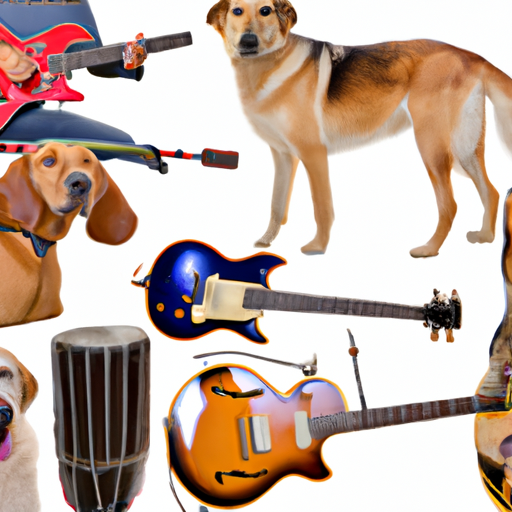

In [31]:
classifier(test_img, test_snd)